In [118]:
import pandas as pd
import os
import requests
import bs4 as bs
import nltk
import re
from nltk.corpus import words, stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, sent_tokenize, pos_tag
#from gensim import corpora
import spacy
#spacy.load('en')
from spacy.lang.en import English

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

import pyLDAvis.gensim
import warnings
import pickle
import gensim
from nltk.corpus import wordnet as wn
from gensim import corpora

import matplotlib.pyplot as plt

from gensim.models import Word2Vec 

warnings.filterwarnings('ignore')

# change the name of the folder you have all the filings in

In [5]:
folder_name = "300_filings"

In [6]:
def load_filings(folder_name):
    filings = []
    files = os.listdir(folder_name)
    for file in files:
        filing = open(folder_name + '/' + file).read()
        filings.append(filing)
    return filings

#### loads the files

In [9]:
files = load_filings(folder_name)

In [55]:
def get_text_from_file(file):
    page_soup = bs.BeautifulSoup(file, 'lxml')
    divs = page_soup.find_all('div')
    all_text = []
    for div in divs:
        text = div.getText()
        if len(text) > 200 and text[0] != '\xa0':
            all_text.append(text)
    return all_text

def combine_text(text):
    file = ""
    for i in range(len(text)):
        ## removes all the /xa0 /n /t garbage and some extra spaces
        cleaner_text = re.sub('\s+', ' ', text[i]).strip()
        file = file + " " + cleaner_text
        
    return file

def get_all_files(files):
    all_files = []
    for file in files:
        text = get_text_from_file(file)
        filing = combine_text(text)
        
        all_files.append(filing)
        
    return all_files

#### Gets the files and scrapes the text so it's semi-readable -- takes a couple minutes for 300

In [119]:
all_files = get_all_files(files)

In [62]:
more_stop_words = ['company','months','products','operations','income','period','sales','market','business','stock','results',
                  'revenue','shares','share','revenues','assets','statements','value','costs','product','quarter','increase',
                  'expense','customers','performance','interest','charges','price','compensation','agreement','property','amount',
                  'markets','information','expenses','facility','customer','taxes','demand','payments',
                  'stringitemtype','textblockitemtype']

## Check the maxlength of all the SEC files first

The max length for the 300 I checked was < 2 million. We can only look at 999,999 at a time so I'll have to slightly alter the prepare_text() function for if there's a longer report.

In [122]:
max_length = 0
for file in all_files:
    length = len(file)
    if length > max_length:
        max_length = length
        
max_length

1407810

In [124]:
en_stop = nltk.corpus.stopwords.words('english')
en_stop.extend(more_stop_words)
parser = English()

def tokenize(text):
    '''
    Separates each word from the others, making them lower case and removing URLs and possible screen names that show up.
    '''

    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

def prepare_text(text):
    '''
    Tokenizes the text, removes short words, removes stop words, and then gets the lemma of each word.
    '''

    if len(text)> 2*(10**6)-1 :
        print(len(text))
    
    if len(text)> 10**6 - 1 :
        text1 = text[:999999]
        text2 = text[999999:]
        tokens = tokenize(text1) + tokenize(text2)
    else:
        tokens = tokenize(text)
        
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token[0]!='-']
    tokens = [token for token in tokens if token[0]!='x']
    tokens = [token for token in tokens if token not in en_stop]
    
    pos_tags = nltk.pos_tag(tokens)
    tokens = [pos_tag[0] for pos_tag in pos_tags if pos_tag[1][0] == "N"]
    
    final_text = ""
    
    #for token in tokens:
    #    final_text = final_text + " " + token
    
    ## do we want lemma?
    ##tokens = [get_lemma(token) for token in tokens]
    return tokens

def prepare_all(all_files):
    prepared_filings = []
    for file in all_files:
        tokens = prepare_text(file)
        prepared_filings.append(tokens)
    
    return prepared_filings

In [125]:
def get_lda_display(prepared_filings,NUM_TOPICS = 10):
    '''
    displays a lda plot for the reviews
    '''

    dictionary = corpora.Dictionary(prepared_filings)
    corpus = [dictionary.doc2bow(text) for text in prepared_filings]

    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')

    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    ldamodel.save('model5.gensim')
    topics = ldamodel.print_topics(num_words=5)


    dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
    corpus = pickle.load(open('corpus.pkl', 'rb'))
    lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
    lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
    #pyLDAvis.display(lda_display)
    return lda_display

# 25 minutes to run

In [126]:
prepared_files = prepare_all(all_files)

In [127]:
lda_display = get_lda_display(prepared_files, 10)
pyLDAvis.display(lda_display)

In [113]:
def prepare_text_for_kmeans(text):
    '''
    Tokenizes the text, removes short words, removes stop words, and then gets the lemma of each word.
    '''
    
    if len(text)> 2*(10**6)-1 :
        print(len(text))
    
    if len(text)> 10**6 - 1 :
        text1 = text[:999999]
        text2 = text[999999:]
        tokens = tokenize(text1) + tokenize(text2)
    else:
        tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    
    pos_tags = nltk.pos_tag(tokens)
    tokens = [pos_tag[0] for pos_tag in pos_tags if pos_tag[1][0] == "N"]
    
    final_text = ""
    
    for token in tokens:
        final_text = final_text + " " + token
    
    ## do we want lemma?
    ##tokens = [get_lemma(token) for token in tokens]
    return final_text

# Takes a long ass time too

In [114]:
text_data = []
for file in all_files:
    tokens = prepare_text_for_kmeans(file)
    text_data.append(tokens)

In [115]:
tfidf = TfidfVectorizer()
tfidf_model = tfidf.fit_transform(text_data)

tfidf_model.shape

(328, 16594)

In [116]:
kmeans4 = KMeans(n_clusters=4).fit_predict(tfidf_model)
PCA4 = PCA(n_components=2).fit_transform(tfidf_model.todense())

kmeans2 = KMeans(n_clusters=2).fit_predict(tfidf_model)
PCA2 = PCA(n_components=2).fit_transform(tfidf_model.todense())

Text(0.5, 1.0, '4 Clusters')

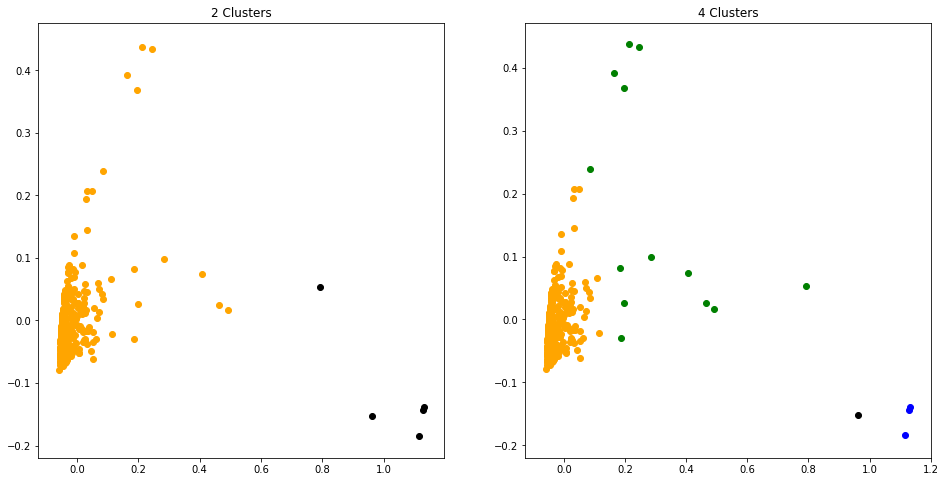

In [117]:
colors = ['orange', 'black', 'green', 'blue']

fig, ax = plt.subplots(1,2, figsize=(16,8))
for cls, col in enumerate(colors[:4]):
    cls2 = PCA2[kmeans2 == cls]
    cls4 = PCA4[kmeans4 == cls]
    ax[0].scatter(cls2[:,0], cls2[:,1], color=col)
    ax[1].scatter(cls4[:,0], cls4[:,1], color=col)
ax[0].set_title("2 Clusters")
ax[1].set_title("4 Clusters")